### Trying to reproduce the figures in [Martingale Posterior Distributions]

In [1]:
import scipy.stats as scs
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad,cumtrapz
from itertools import combinations


# Figure 1:



Data density $f(y) = N(\theta,1)$ with prior $\Pi(\theta) = N(0,1)$

This results in the predictive $p(y|y_{1:n}) = N(y|\bar{\theta_n}, 1+\bar{\sigma^{2}_{n}})$ with
$\bar{\theta_n} = \frac{\sum_{i=1}^{n} y_i }{n+1}$ and $\bar{\sigma^{2}_{n}} = \frac{1}{n+1}$.

The posterior density $\Pi(\theta|y_{1:n})=N(\theta|\bar{\theta_n},\bar{\sigma^{2}_n})$

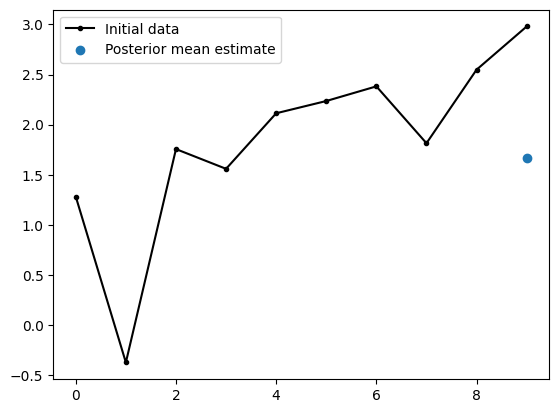

In [5]:
# Set true parameters: theta the mean, n the initial obs

theta = 2
n = 10

initial_obs_data = scs.norm.rvs(loc=2,scale=1,size=n)
plt.plot(initial_obs_data,label='Initial data',marker='.',color='black')
plt.scatter(x=9,y=np.sum(initial_obs_data)/11,label='Posterior mean estimate')
plt.legend()
plt.show()

In [6]:
# paths for posterior estimate
nb_paths = 100
nb_steps = 1000

list_of_mean_paths = []
list_of_paths = []
for path in tqdm(range(nb_paths)):
    current_path = list(initial_obs_data)
    mean_of_path = [np.sum(initial_obs_data)/11]
    for step in range(nb_steps):
        obs = scs.norm.rvs(loc=mean_of_path[step],scale=(1/(11+step))+1)
        current_path.append(obs)
        #update mean and var
        mean_of_path.append(np.sum(current_path)/(12+step))
    list_of_mean_paths.append(mean_of_path)
    list_of_paths.append(current_path)

100%|██████████| 100/100 [00:08<00:00, 12.36it/s]


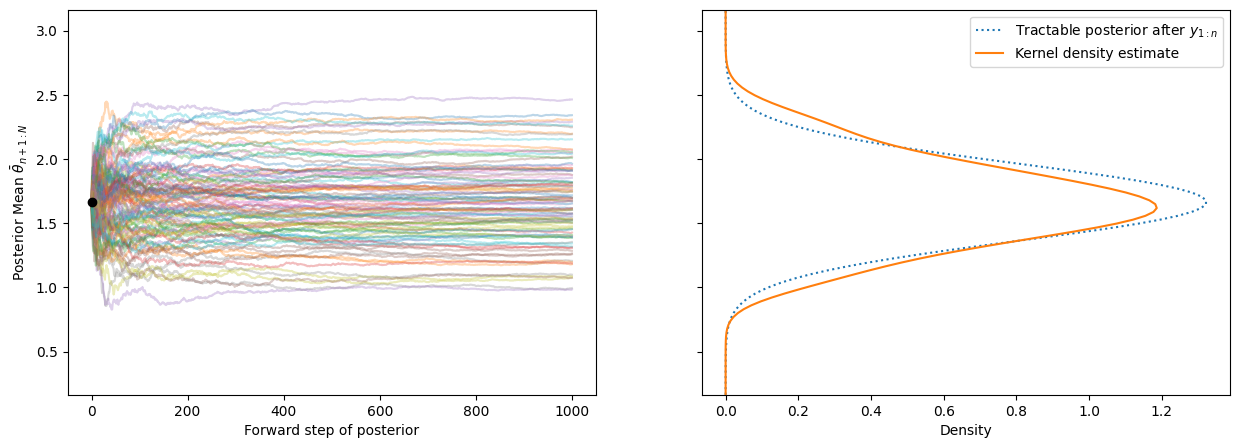

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True,figsize=(15,5))
for idx,ax in enumerate(ax.flat):
    ax.set(ylabel='Posterior Mean '+r'$\bar{\theta}_{n+1:N}$')
    ax.label_outer()
    if idx ==0:
        ax.plot(np.transpose(np.array(list_of_mean_paths)),alpha=0.3)
        ax.set_ylim([np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5])
        ax.scatter(0,np.sum(initial_obs_data)/11,color='black',zorder=10)
        ax.set(xlabel='Forward step of posterior')
    if idx==1:
        x = np.linspace(np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5,100)
        posterior = scs.norm(loc=np.sum(initial_obs_data)/11,scale=np.sqrt(1/11))
        ax.plot(posterior.pdf(x),x,label='Tractable posterior after '+r'$y_{1:n}$',linestyle='dotted')

        ax.plot(scs.gaussian_kde(np.array(list_of_mean_paths)[:,-1]).evaluate(x),x,label='Kernel density estimate')
        ax.legend()
        ax.set_ylim([np.sum(initial_obs_data)/11-1.5,np.sum(initial_obs_data)/11+1.5])
        ax.set(xlabel='Density')


# Hahn $et \, al.$ in the case of Normal conjugacy:



Covers the case of univariate Normal, which gives rise to an analytically tractable update. We have:

Data density $f(y|\theta)=N(y|\theta,1)$ with (conjugate) prior $N(\theta)=N(\theta|0,\tau^{-1})$, here we will choose $\tau = 1$.

The predictive updates are then parameterised by a Gaussian copula with correlation parameter $\rho_n=(n+\tau)^{-1}$. In particular, the prequential copula used to propagate the predictive density is:

$c_{\rho}(u,v)=\frac{N_2(\Phi^{-1}(u),\Phi^{-1}(v)|0,1,\rho)}{N(\Phi^{-1}(u)|0,1)\cdot N(\Phi^{-1}(v)|0,1)}$


Finally, the predictive density is given by:

$p_{n-1}(y)=N(y|\frac{T_{n-1}}{n-1+\tau},\frac{n+\tau}{n-1+\tau})$ with  $T_{n-1}=y_1+\cdots+    y_{n-1}$


STATUS: recursion is working, but I encountered a bottleneck due to integration. Since we are working on densities, the distribution terms inside copulas whoch relate to the new observation ($u=F_(i-1)(x)$) are not known and have to instead be computed as integrals of $f_(i-1)$ from -inf to x. Because of the recursion, we have to compute an increasing number of these integrals, causing a 10x increase in time at each step. -this is where I started working on the DPMM example instead.

In [264]:
# density function
def p(x,theta,v):
    return scs.norm(loc=theta).pdf(x)

# function for copula based update
def update_p(p_,rho):
    def updated_p(x,theta,v):
        inv_u = scs.norm.ppf(np.clip(quad(p_,-np.inf,x,args=(0,v),limit=1,epsabs=1e-2,epsrel=1e-2)[0],1e-20,1-(1e-10)))
        inv_v = scs.norm.ppf(v)
        out = scs.multivariate_normal.logpdf((inv_u,inv_v),mean=np.zeros(2),cov=np.array([1,rho,rho,1]).reshape(2,2)) 
        out -= scs.norm.logpdf(inv_v)
        out -= scs.norm.logpdf(inv_u)
        out += np.log(np.clip(p_(x,theta,v),1e-6,1-(1e-6)))
        return np.exp(out)
    return updated_p

In [265]:
# update step 0
predictives = []
predictives.append(p)
predictives.append(update_p(predictives[0],0))
predictives.append(update_p(predictives[1],0))
predictives.append(update_p(predictives[2],0))

# as proposal in IS, use a T dist




In [266]:
predictives = []
predictives.append(p)
for i in range(5):
    predictives.append(update_p(predictives[i],0))

In [ ]:
predictives[2](0,0,np.random.uniform())

# DPMM example, section 4.2 in the RSS paper

Here, they have a form for the recursions of densities $f_i(x)$ and distributions $F_i(x)$, solving the problem of integration in the normal case.

In [2]:
# Initial distribution. I take it to be a guess as a Gaussian.
def F_0(z,theta): 
    return scs.norm.logcdf(z, loc=theta)
def f_0(x,theta):
    return scs.norm.logpdf(x, loc=theta)
    
# functions for copula-based update.

rho = 0.95 #correlation parameter for copula, value is recommended by authors.

def update_(F_,f_,alpha,v,rho):
    # Mostly done using equations 4.4 and 4.5 from the RSS paper.

    def updated_F(z,theta): # define F_(i+1)(z), will be returned.
        cop_term = ( scs.norm.ppf( np.exp(F_(z,theta)) ) - rho*scs.norm.ppf(v) ) / np.sqrt(1-np.power(rho,2))
        # main expression below:
        out = np.exp(  np.log(1-alpha) + F_(z,theta)  ) + np.exp(  np.log(alpha) + scs.norm.logcdf(cop_term)  )
        return np.log(np.clip(out,1e-6,1-(1e-6)))
    
    def updated_f(x,theta): # define f_(i+1), will be returned.
        inv_u = scs.norm.ppf( np.clip(np.exp(F_(x,theta)),1e-10,1-(1e-10)) )
        cop_term = scs.multivariate_normal.logpdf( [float(inv_u),float(scs.norm.ppf(v))] , mean=np.zeros(2), cov=(np.array([1,rho,rho,1]).reshape(2,2)) )
        cop_term += -scs.norm.logpdf(inv_u) -scs.norm.logpdf(scs.norm.ppf(v))

        # main expression below:
        out = np.exp(  np.log(1-alpha) + f_(x,theta)  ) + np.exp( np.log(alpha) + cop_term + f_(x,theta) )
        return np.log(np.maximum(out,1e-100))
    
    return updated_F,updated_f


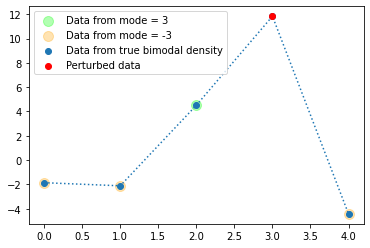

In [3]:
# Generating observations function: generate_data(nb_obs)

obs_nb = 5 # Specify number of observations.

def generate_data(obs_nb= obs_nb):
    observed_data = []
    mode1_idx = []
    mode2_idx = []

    for k in range(obs_nb):
        if k==3:
            observed_data.append(scs.norm.rvs(loc=10,size=1))
            continue
        if np.random.uniform()<0.5:
            observed_data.append(scs.norm.rvs(loc=3,size=1))
            mode1_idx.append(k)
        else:
            observed_data.append(scs.norm.rvs(loc=-3,size=1))
            mode2_idx.append(k)

    plt.plot(observed_data,linestyle='dotted')
    plt.scatter(mode1_idx,[observed_data[k] for k in mode1_idx],color='lime',s=100,label='Data from mode = 3',alpha=0.3)
    plt.scatter(mode2_idx,[observed_data[k] for k in mode2_idx],color='orange',s=100,label='Data from mode = -3',alpha=0.3)
    plt.scatter(range(obs_nb),observed_data,label='Data from true bimodal density')
    plt.scatter(3,observed_data[3],color='red',zorder=10,label='Perturbed data')
    plt.legend()
    plt.show()

    return(observed_data)
observed_data = generate_data(obs_nb)

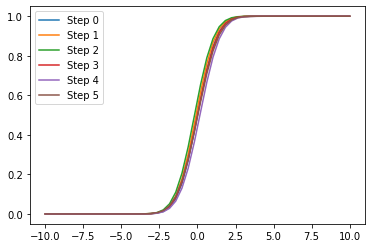

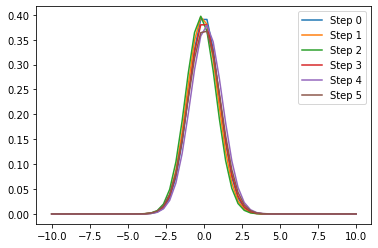

In [4]:
# updating for K steps:
F_ = [F_0]
f_ = [f_0]
rho=0.1
obs_nb = len(observed_data)

for step in range(obs_nb):
    rv = np.clip(np.exp(F_[step](observed_data[step],0)),1e-6,1-(1e-6))
    alpha_i = (2-(1/(step+1))) / (step +2)
    new_dist = update_(F_[step],f_[step],alpha_i,rv,rho=rho)
    F_.append(new_dist[0])
    f_.append(new_dist[1])

# plots for the 6 functions:
for step in range(obs_nb+1):
    plt.plot(np.linspace(-10,10,50),[np.exp(F_[step](i,0)) for i in np.linspace(-10,10,50)],label='Step '+str(step))
plt.legend()
plt.show()
for step in range(obs_nb+1):
    plt.plot(np.linspace(-10,10,50),[np.exp(f_[step](i,0)) for i in np.linspace(-10,10,50)],label='Step '+str(step))
plt.legend()
plt.show()

### Energy Prequential Scoring Rule

Try: when computing functions, at each new step, compute the f_i(obs) and F_i(obs) for all observations and store. This way, you can come back to evaluate the values in later steps, without having to redo the whole recusion.

In [42]:
# Compute energy SR via importance sampling, for a given rho
def Energy_SR_via_IS(obs_,q_samples,q_evals,p_targets,b):

    N = len(q_samples) # IS iterations
    comb = [i for i in combinations(range(N),2)]
    out = 0

    for i in range(len(obs_)): # loop over observed data

        # compute weights
        f_x = np.fromiter( (p_targets[i](x,0) for x in q_samples) ,float)
        weights = np.exp(np.subtract(f_x,q_evals))
        # compute first part of Energy Score: 2*w*|x-y|
        out += (2/ np.sum(weights)) * np.sum(np.fromiter( ( weights[j]*np.power(np.linalg.norm(q_samples[j]-obs_[i]),b) for j in range(N) ) ,float))

        # compute second part of Energy Score: w_x*w_z*|w-z| / w_x*w_z
        out -= (np.sum(np.fromiter(  ( weights[idx[0]]*weights[idx[1]] * np.power(np.linalg.norm(q_samples[idx[0]]-q_samples[idx[1]]),b) for idx in comb ) ,float)))  /  (np.sum(np.fromiter( ( weights[idx[0]]*weights[idx[1]] for idx in comb ) ,float)))

    return out



#Energy_SR_via_IS(obs_=observed_data,q_samples=q_samples,q_evals_=q_evals,p_targets=f_)


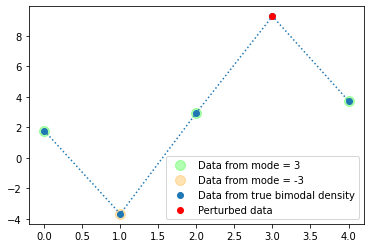

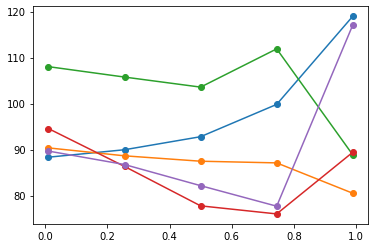

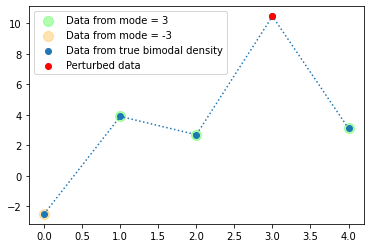

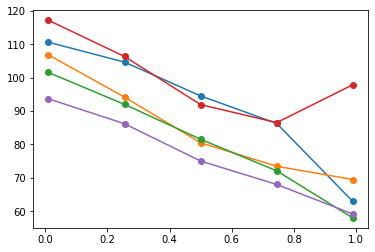

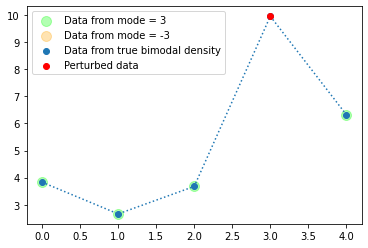

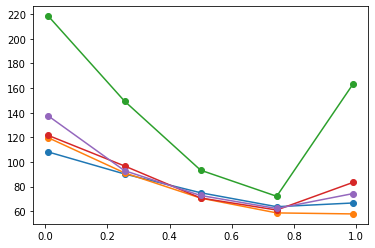

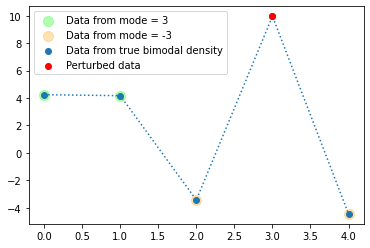

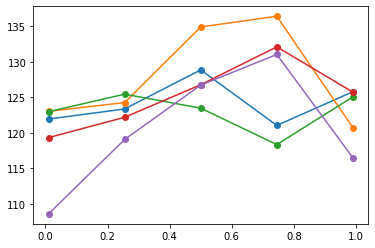

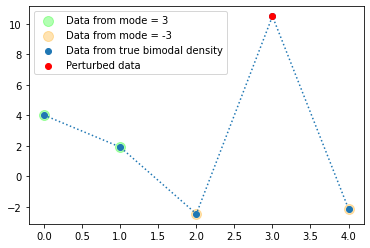

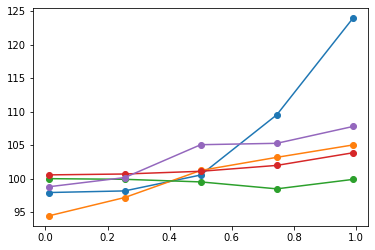

In [45]:
# function to evaluate the scoring rule for a given rho.
for aaaaaaaaaa in range(5):
    observed_data = generate_data(5)
    for attempt in range(5):
        
        samples = scs.norm(loc=0,scale=30).rvs(size=100)
        evals=scs.norm(loc=0,scale=30).logpdf(samples)
        def f_call_rho(rho):
            F_ = [F_0]
            f_ = [f_0]

            for step in range(len(observed_data)):
                rv = np.exp(F_[step](observed_data[step],0))
                alpha_i = (2-(1/(step+1))) / (step +2)
                new_dist = update_(F_[step],f_[step],alpha_i,rv,rho=rho)
                F_.append(new_dist[0])
                f_.append(new_dist[1])
            
            return Energy_SR_via_IS(observed_data,samples,evals,f_,1.5)
        
        plt.plot(np.linspace(0.01,0.99,5),[f_call_rho(i) for i in np.linspace(0.01,0.99,5)],'o-')
    plt.show()

### SR for an example where the goal is to estimate the mean of a normal dist. Comparing the MC implementation vs the IS for the energy score - trying to see what the issue is.

In [159]:
# testing SR and SR via IS:

obs_data = scs.norm.rvs(loc=3,size=10)

def SR_MC(obs_data,test_samples):
    out = 0
    N=len(test_samples)
    comb = [i for i in combinations(range(N),2)]

    for i in range(len(obs_data)):
        # part 1:
        out += (2/N) * np.sum( np.fromiter( (np.power(np.linalg.norm(test_samples[k]-obs_data[i]),1.5) for k in range(N)) ,float) )
        #part 2:
        out -= (1/(N*(N-1))) * np.sum( np.fromiter( ( np.power(np.linalg.norm(test_samples[idx[0]]-test_samples[idx[1]]),0.5) for idx in comb ) ,float) )
    return out

def SR_MC_eval(theta):
    samples = scs.norm.rvs(loc=theta,size=100)
    return SR_MC(obs_data=obs_data,test_samples=samples)

######

def Energy_SR_via_IS(obs_,samples,evals_,target,b):

    N = len(samples) # IS iterations
    comb = [i for i in combinations(range(N),2)]
    out = 0

    for i in range(len(obs_)): # loop over observed data

        # compute weights
        f_x = np.fromiter( (target(x) for x in samples) ,float)
        weights = np.exp(np.subtract(f_x,evals_))

        # compute first part of Energy Score: 2*w*|x-y|
        # Self-normalised:
        out += (2/(np.sum(weights))) *np.sum(np.fromiter( (weights[k]*np.power(np.linalg.norm(samples[k]-obs_[i]),b) for k in range(N)) ,float))
        # Basic:
        #out += (2/N) *np.sum(np.fromiter( (weights[k]*np.power(np.linalg.norm(samples[k]-obs_[i]),b) for k in range(N)) ,float))

        # compute second part of Energy Score: w_x*w_z*|w-z| / w_x*w_z
        # Self-normalised
        out -= (np.sum(np.fromiter(  ( weights[idx[0]]*weights[idx[1]] * np.power(np.absolute(np.subtract(samples[idx[0]],samples[idx[1]])),b)   for idx in comb )  ,float))  /  (np.sum(np.fromiter(  (weights[idx[0]]*weights[idx[1]]  for idx in comb)  ,float))))
        # Basic:
        #out -= (np.sum(np.fromiter(  ( weights[idx[0]]*weights[idx[1]] * np.power(np.absolute(np.subtract(samples[idx[0]],samples[idx[1]])),b)   for idx in comb )  ,float))  /  (N*(N-1)))

    return out

def SR_IS_eval(theta):
    samples = scs.norm.rvs(loc=0,scale=10,size=100)
    samples_eval = scs.norm(loc=0,scale=10).logpdf(samples)
    target = scs.norm(loc=theta).logpdf
    return Energy_SR_via_IS(obs_=obs_data,samples=samples,evals_=samples_eval,target=target,b=1.5)



In [160]:
MC_test = [SR_MC_eval(kek) for kek in np.linspace(0,6,10)]
IS_test = [[SR_IS_eval(kek) for kek in np.linspace(0,6,10)] for k in range(5)]

Text(0.5, 1.0, 'SUM(w_x*w_z)')

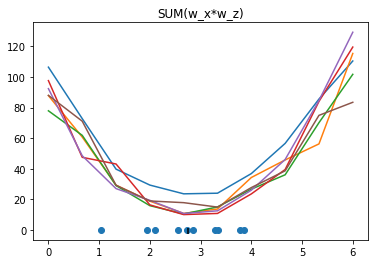

In [162]:
plt.plot(np.linspace(0,6,10),MC_test)
for attempt in range(5):
    plt.plot(np.linspace(0,6,10),IS_test[attempt])
plt.scatter(obs_data,np.repeat(0,len(obs_data)))
plt.scatter(np.mean(obs_data),1,color='black',marker=3)
plt.title('SUM(w_x*w_z)')


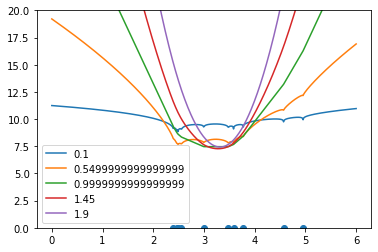

In [124]:
for p in np.linspace(0.1,1.9,5):
    plt.plot(np.linspace(0,6,500),[np.sum([np.power(abs(x-obs),p) for obs in obs_data]) for x in np.linspace(0,6,500)],label=str(p))
    
plt.scatter(obs_data,np.repeat(0,len(obs_data)))
plt.ylim(0,20)
plt.legend()

### Maximising the log-density of observed data:


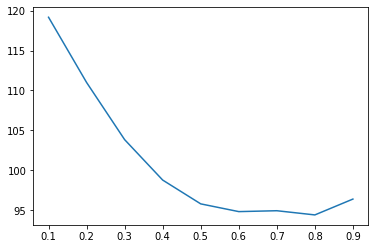

In [141]:
def prequential_nll(rho):
    F_ = [F_0]
    f_ = [f_0]

    for step in range(len(observed_data)):
        rv = np.exp(F_[step](observed_data[step],0))
        alpha_i = (2-(1/(step+1))) / (step +2)
        new_dist = update_(F_[step],f_[step],alpha_i,rv,rho=rho)
        F_.append(new_dist[0])
        f_.append(new_dist[1])
    return np.sum(np.fromiter((-f_[i](observed_data[i],0) for i in range(len(observed_data))),float))

plt.plot(np.linspace(0.1,0.9,9),np.fromiter((prequential_nll(rho/10) for rho in range(1,10)),float))

# Comparing the estimated fit from SR and from log-density in the DPMM example

<function matplotlib.pyplot.show(close=None, block=None)>

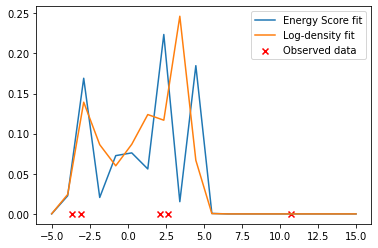

In [108]:
# energy score fit
F_ = [F_0]
f_ = [f_0]

rho=0.9

for step in range(len(observed_data)):
    rv = np.exp(F_[step](observed_data[step],0))
    alpha_i = (2-(1/(step+1))) / (step +2)
    new_dist = update_(F_[step],f_[step],alpha_i,rv,rho=rho)
    F_.append(new_dist[0])
    f_.append(new_dist[1])

plt.plot(np.linspace(-5,15,20),np.fromiter((np.exp(f_[5](x,0)) for x in np.linspace(-5,15,20)),float),label='Energy Score fit')

### log - density fit
F_ = [F_0]
f_ = [f_0]

rho=0.7

for step in range(len(observed_data)):
    rv = np.exp(F_[step](observed_data[step],0))
    alpha_i = (2-(1/(step+1))) / (step +2)
    new_dist = update_(F_[step],f_[step],alpha_i,rv,rho=rho)
    F_.append(new_dist[0])
    f_.append(new_dist[1])

plt.plot(np.linspace(-5,15,20),np.fromiter((np.exp(f_[5](x,0)) for x in np.linspace(-5,15,20)),float),label='Log-density fit')


plt. scatter(observed_data,[0 for k in range(len(observed_data))],color='red',marker='x',label='Observed data')
plt.legend()
plt.show

In [143]:
len(f_)

12

# Notes on how this works.

In the 2022 paper, $y_{i+1}$ is the current observation, to which we have access and $y$ is the future observation we are simulating.